Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
Необходимо модель классифицировать комментарии на позитивные и негативные. Набор данных с разметкой о токсичности правок будет использоваться в качестве обучения.

Значение метрики качества F1 должно быть не меньше 0.75. 

В заданном датасете столбец text одержит текст комментария, а toxic — целевой признак.

In [23]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.pipeline import make_pipeline 
from nltk.corpus import stopwords 
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import re 

from tqdm import tqdm

from lightgbm import LGBMClassifier
from lightgbm import plot_importance

from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [2]:
#nltk.download('stopwords') 
# nltk.download('punkt')

In [3]:
#download the data

try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('D:/yandex_praktikum/toxic_comments.csv')

In [4]:
data.sample()

,Unnamed: 0,text,toxic
65572,65639,Dont I know to answer that. Why are you coming...,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [6]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

## Modelling

### Prepare the data

In [14]:
##Lemmatizing the text

# nltk.download('wordnet')
m = WordNetLemmatizer() 

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


text_lemmatized = data['text'].progress_apply(lambda x: [m.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(x)])
data['lemm_text'] = text_lemmatized.apply(lambda x: " ".join(string))



In [17]:
data['lemm_text'] = text_lemmatized.apply(lambda x: " ".join(x))

In [8]:
pd.Series(text_lemmatized)

0         Explanation Why the edits made under my userna...
1         D'aww ! He matches this background colour I 'm...
2         Hey man , I 'm really not trying to edit war ....
3         `` More I ca n't make any real suggestions on ...
4         You , sir , are my hero . Any chance you remem...
                                ...                        
159287    `` : : : : : And for the second time of asking...
159288    You should be ashamed of yourself That is a ho...
159289    Spitzer Umm , theres no actual article for pro...
159290    And it looks like it was actually you who put ...
159291    `` And ... I really do n't think you understan...
Length: 159292, dtype: object

In [19]:
#clear the lemmitized text from punktuation

def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text) 
    text = text.split() 
    return " ".join(text)

text_cleared = pd.Series(data['lemm_text']).apply(lambda x: clear_text(x))

In [47]:
#non toxic comments joined in line
non_toxic = ''
for x in text_cleared[data['toxic'] == 0]:
    non_toxic = non_toxic+x

In [49]:
#toxic comments joined in line
toxic = ''
for x in text_cleared[data['toxic'] == 1]:
    toxic = toxic+x

NON TOXIC COMMENTS WORD CLOUD


(-0.5, 399.5, 199.5, -0.5)

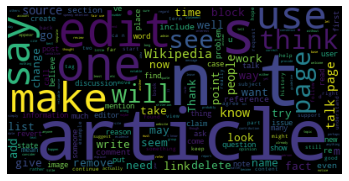

In [51]:
print('NON TOXIC COMMENTS WORD CLOUD')

cloud = WordCloud().generate(non_toxic)
plt.imshow(cloud)
# Отключаем отображение осей
plt.axis('off')

TOXIC COMMENTS WORD CLOUD


(-0.5, 399.5, 199.5, -0.5)

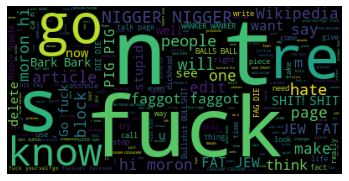

In [52]:
print('TOXIC COMMENTS WORD CLOUD')


cloud = WordCloud().generate(toxic)
plt.imshow(cloud)
# Отключаем отображение осей
plt.axis('off')

In [10]:
#split the data into target and features
#target is 0 or 1
#features are cleared text corpus

features = text_cleared
target = data['toxic']

In [11]:
#split the data into test and train 

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=22, stratify=target) 

In [12]:
#create TF-IDF counter for the cleared text. This will be the feature in model

corpus = features_train.apply(lambda x: x.lower())
stop_words = stopwords.words('english') 
count_tf_idf = TfidfVectorizer(stop_words=stop_words) 
feat_train = count_tf_idf.fit_transform(corpus)

In [13]:
#test features

feat_test = count_tf_idf.transform(features_test)

In [14]:
#we will use F1 metrics for scoring

f1 = make_scorer(f1_score, greater_is_better=True)

### Logistic Regression

In [21]:
LR_clf = make_pipeline(
    TfidfVectorizer(stop_words=stop_words) , 
    LogisticRegression(random_state=0, max_iter = 1000, class_weight='balanced'))

In [22]:
print('Mean F1 metrics for Logistic Regression', cross_val_score(
    LR_clf,corpus, target_train,
    scoring=f1, cv=5).mean())


Mean F1 metrics for Logistic Regression 0.7484339555127411


### Random Forest Classifier

In [23]:
RF_model = RandomForestClassifier(class_weight='balanced', random_state = 42)
parameters = {
    'max_depth' : [100],#, 300
    
    'n_estimators' : [5, 12]
}

RF_clf = GridSearchCV(RF_model, parameters, scoring=f1)
RF_clf.fit(feat_train, target_train)

In [ ]:
RF_clf.best_score_

In [ ]:
RF_clf.best_params_

### LightGBM

In [15]:
modl_LGBM = LGBMClassifier(boosting_type='gbdt')

In [17]:
parameters = {'learning_rate': [0.3, 0.5], 'max_depth':[10, 25]}
modl_LGBM = LGBMClassifier()
result = GridSearchCV(modl_LGBM, parameters, scoring=f1)
modl_LGBM = result.fit(feat_train, target_train)

In [18]:
print(result.best_score_)

0.7668008686066934


## Test the model

In [19]:
prediction = modl_LGBM.predict(feat_test)

In [20]:
f1_score(target_test, prediction)

0.7710255963781995

## Conclusion

In this project we classified text comments into toxic and non-toxic.
First we lemmatized and cleared the comments given. Then we divided the dataset into traning and test samples.
We used logistic regression, random forest and LightGBM model and F1 metrics for quality assessment. Cross validation for logistic regression gave us F1 of the model =0.74. Random forest classifier is much worser.
The best F1 metrics is observed for LightGBM model (F1=) with parameters  . After predicting on the test sample, F1 equals  , that is more than 0.75.